In [2]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import pandas as pd
from pathlib import Path
from segmentflow import segment, view
from skimage import exposure, filters, measure, morphology
%load_ext autoreload
%autoreload 2

This notebook tests different morphologic operations on a manual semantic
segmentation on an SEM back-scattered electron (BSE) image of
IDOX-Estane collected by Nate Peterson at Colorado School of Mines.

(481, 555)
(481, 555)


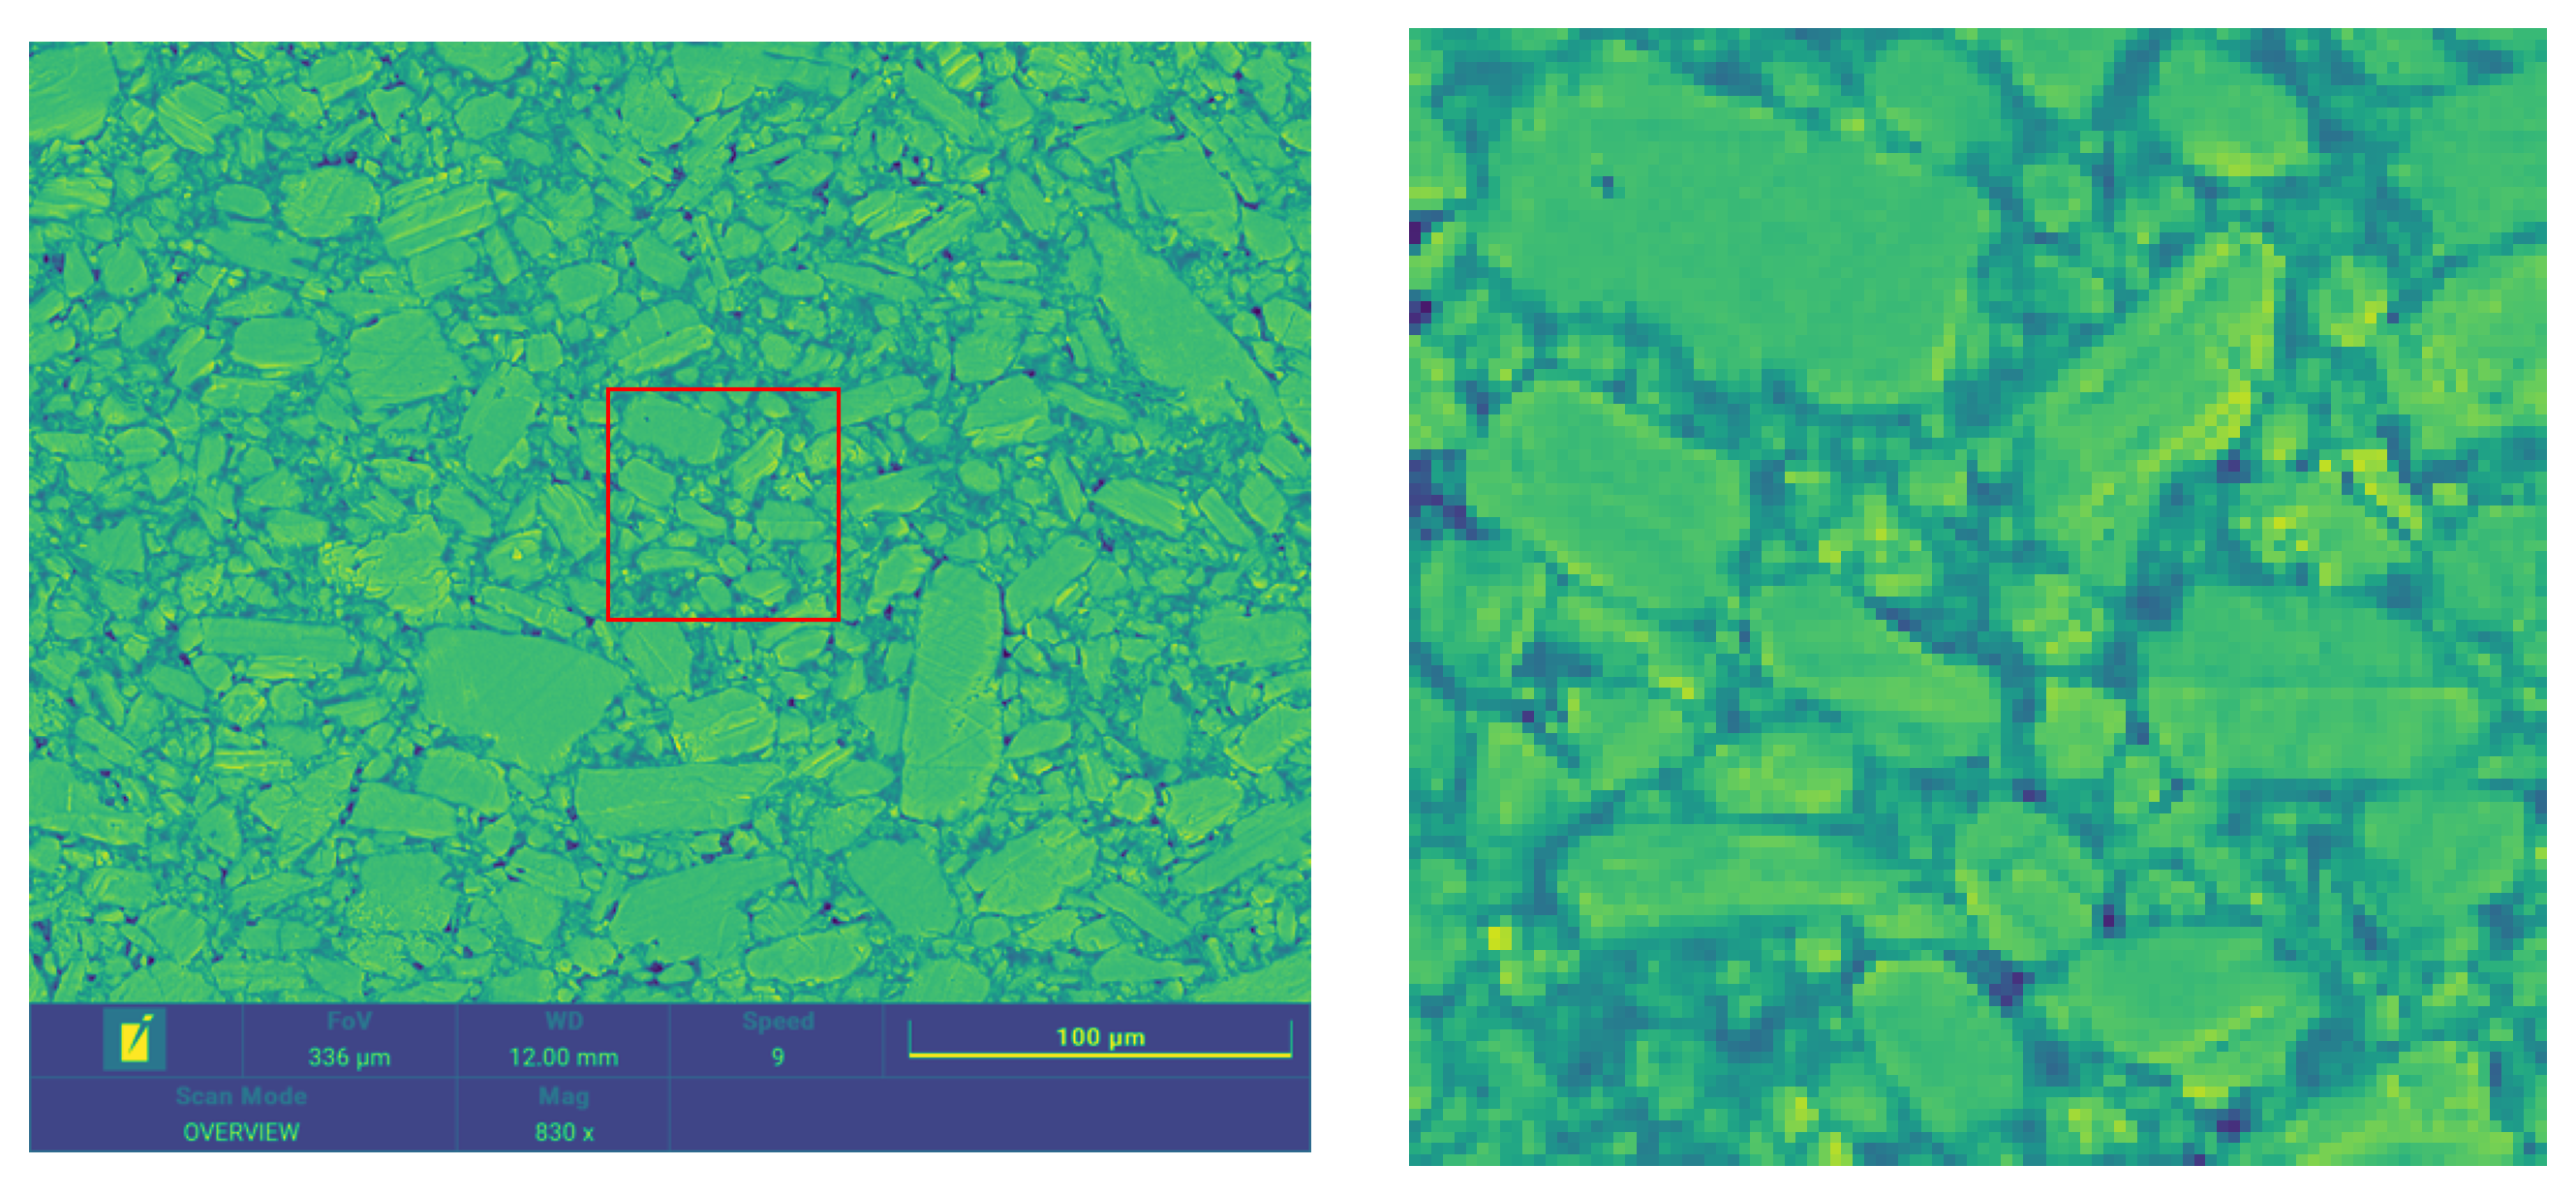

In [3]:
# %matplotlib qt
%matplotlib inline
img_dir_path = Path('../data/sem_idox_estane2.tif')
img = iio.imread(img_dir_path)
print(img.shape)
# img = img[:400, :]
print(img.shape)
fig, axes = plt.subplots(
    1, 2, dpi=300, facecolor='white', figsize=(9, 4),
    constrained_layout=True)
axes[0].imshow(img, vmin=img.min(), vmax=img.max())
row_crop = [150, 250]
col_crop = [250, 350]
rect = patches.Rectangle(
    (col_crop[0], row_crop[0]),
    col_crop[1]-col_crop[0], row_crop[1]-row_crop[0],
    linewidth=1, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)
img_crop = img[row_crop[0]:row_crop[1], col_crop[0]:col_crop[1]]
axes[1].imshow(
    img_crop, vmin=img.min(), vmax=img.max())
for a in axes:
    a.set_axis_off()

In [4]:
ums_per_pixel = 100 / (546-381)
print(ums_per_pixel)

0.6060606060606061


4680 60909
6 60909
16 65090


c:\Users\gusb\Python\envs\segmentflow-env\lib\site-packages\skimage\filters\rank\generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (60910), equivalent to an approximate bitdepth of 15.9.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


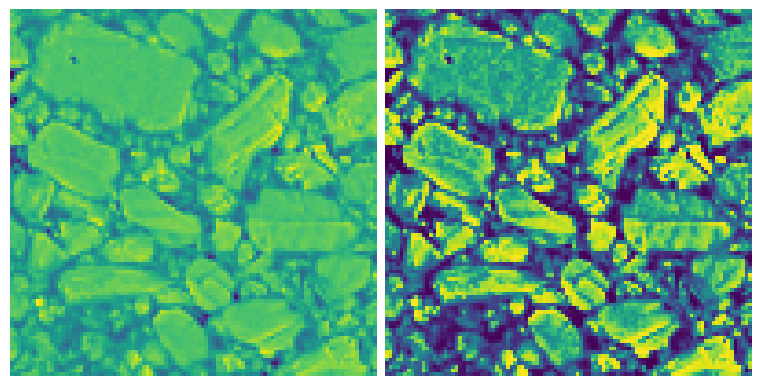

In [5]:
# Equalization
footprint = morphology.disk(200)
print(img_crop.min(), img_crop.max())
img_crop_eq = filters.rank.equalize(img_crop, footprint=footprint)
print(img_crop_eq.min(), img_crop_eq.max())
img_crop_mix = img_crop+img_crop_eq
print(img_crop_mix.min(), img_crop_mix.max())
fig, ax = view.images([img_crop, img_crop_eq])

## Multi-Otsu Threshold

In [6]:
thresh_vals = segment.threshold_multi_otsu(img_crop, nclasses=3)
thresh_vals

Calculating Multi Otsu thresholds...


array([34199, 42423])

Generating histogram...


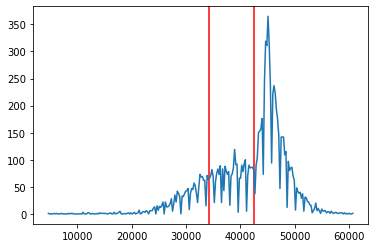

In [7]:
fig, ax = view.histogram(img_crop, mark_values=list(thresh_vals))

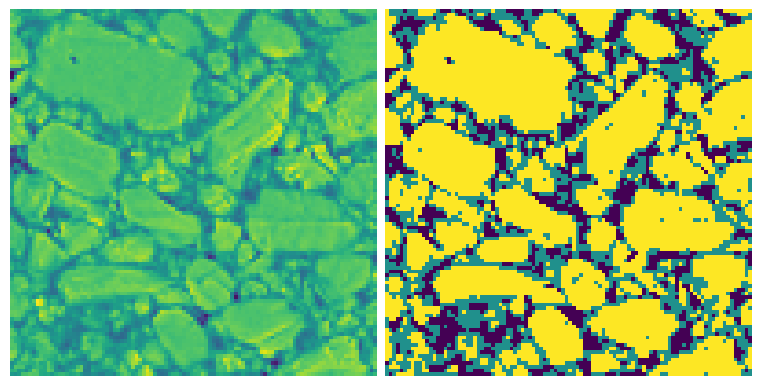

In [8]:
img_sem_mo = segment.isolate_classes(img_crop, list(thresh_vals), intensity_step=1)
fig, ax = view.images([img_crop, img_sem_mo])

In [9]:
img_labeled = img_sem_mo
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_void = np.count_nonzero(img_labeled == 0)
n_binder = np.count_nonzero(img_labeled == 1)
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

--> Crystal area fraction: 0.5793
--> Crystal area fraction (void corrected): 0.688495364868077


## Manual threshold

Generating histogram...
--> Void area fraction: 0.0077
--> Crystal area fraction: 0.8478
--> Crystal area fraction (void corrected): 0.8543787161140785


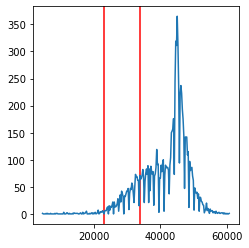

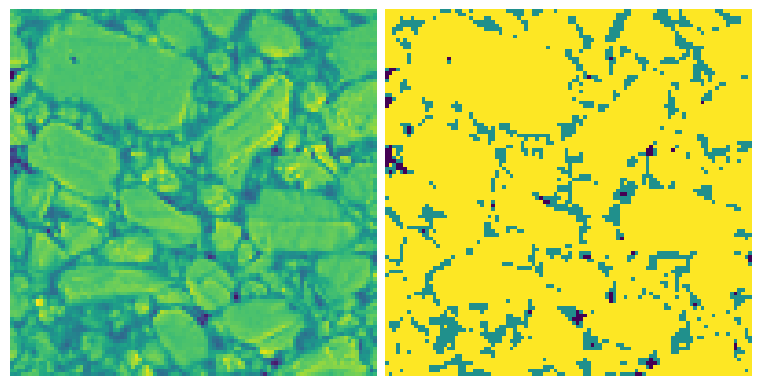

In [10]:
thresh_vals_man = [23000, 34000]
fig, ax = view.histogram(img_crop, mark_values=thresh_vals_man)
ax.set_aspect(65000/400)
img_sem_man = segment.isolate_classes(img_crop, thresh_vals_man, intensity_step=1)
fig, ax = view.images([img_crop, img_sem_man])
img_labeled = img_sem_man
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_void = np.count_nonzero(img_labeled == 0)
n_binder = np.count_nonzero(img_labeled == 1)
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Void area fraction:', n_void / n_pixels)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

## Morphologic Operations

### Erosion/Dilation

--> Void area fraction: 0.0077
--> Crystal area fraction: 0.0
--> Crystal area fraction (void corrected): 0.0


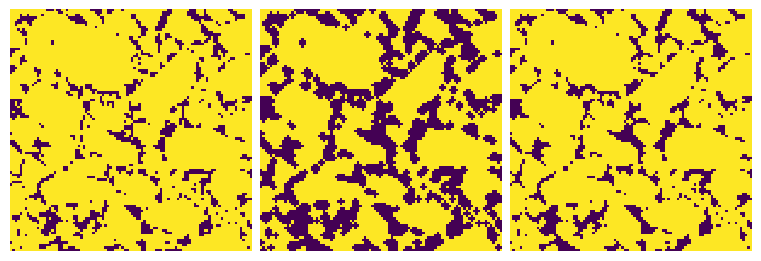

In [11]:
img_bin = img_sem_man.copy() == 2
img_bin_ero = morphology.binary_erosion(img_bin)
img_bin_ero_dil = morphology.binary_dilation(img_bin_ero)
fig, ax = view.images([img_bin, img_bin_ero, img_bin_ero_dil])
img_labeled = img_bin_ero_dil
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Void area fraction:', n_void / n_pixels)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

### Median filter

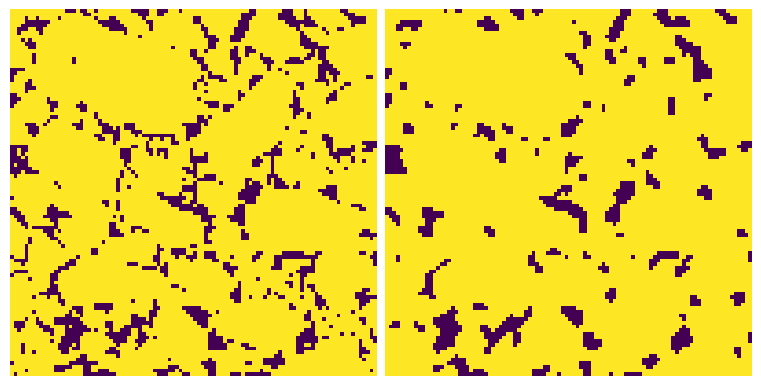

In [12]:
img_bin_med = filters.median(img_bin)
fig, ax = view.images([img_bin, img_bin_med])

## Instance segmentation

Segmenting images...


c:\users\gusb\research\segmentflow\segmentflow\segment.py:1510: RuntimeWarning: When min_distance < 1, peak_local_max acts as finding image > max(threshold_abs, threshold_rel * max(image)).
  maxima = feature.peak_local_max(


--> Segmentation complete. 5 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 265 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 154 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 94 particle(s) segmented.


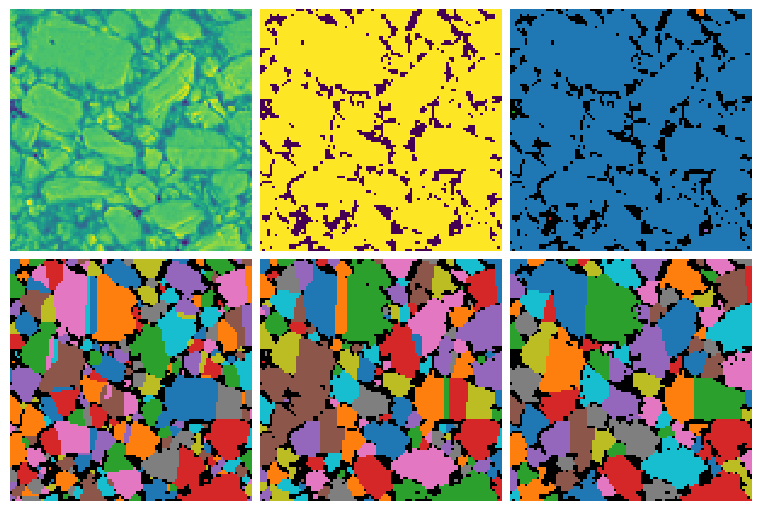

In [13]:
img_labeled_by_msd = {
    msd : segment.watershed_segment(img_bin, min_peak_distance=msd)
    for msd in range(4)
}
color_label_list = [
    view.color_labels(img_labeled_by_msd[msd], return_image=True)
    for msd in range(4)
]
fig, axes = view.images(
    [img_crop, img_bin, *color_label_list],
    imgs_per_row=3, dpi=100)

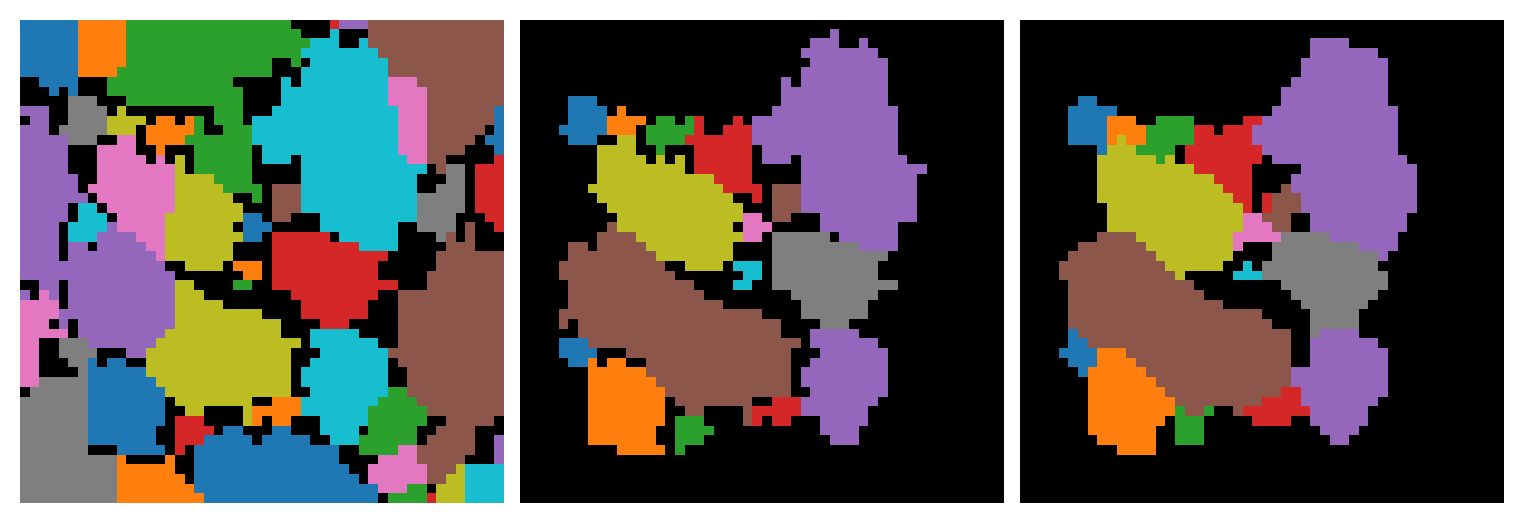

In [14]:
# %matplotlib qt
# fig, ax = view.images(img_1)
%matplotlib inline
img_1 = img_labeled_by_msd[2].copy()[25:75, 25:75]
img_1_merged = np.zeros_like(img_1)
img_1_merged[img_1 == 52] = 1
img_1_merged[img_1 == 53] = 2
img_1_merged[img_1 == 56] = 3
img_1_merged[img_1 == 60] = 4
img_1_merged[img_1 == 54] = 5
img_1_merged[img_1 == 67] = 6
img_1_merged[img_1 == 74] = 7
img_1_merged[img_1 == 79] = 8
img_1_merged[img_1 == 87] = 11
img_1_merged[img_1 == 92] = 12
img_1_merged[img_1 == 97] = 13
img_1_merged[img_1 == 94] = 14
img_1_merged[img_1 == 91] = 15
# Merge 69 & 71
img_1_merged[img_1 == 69] = 9
img_1_merged[img_1 == 71] = 9
# Merge 77 & 78
img_1_merged[img_1 == 77] = 10
img_1_merged[img_1 == 78] = 10
# Merge 80 & 88
img_1_merged[img_1 == 80] = 16
img_1_merged[img_1 == 88] = 16
# Smooth edges
img_1_merged_sm = filters.median(img_1_merged)
# fig, ax = view.images([img_1, img_1_color, img_1_merged], dpi=200)
fig, ax = view.images([
    view.color_labels(img_1, return_image=True),
    view.color_labels(img_1_merged, return_image=True),
    view.color_labels(img_1_merged_sm, return_image=True),
], dpi=200)

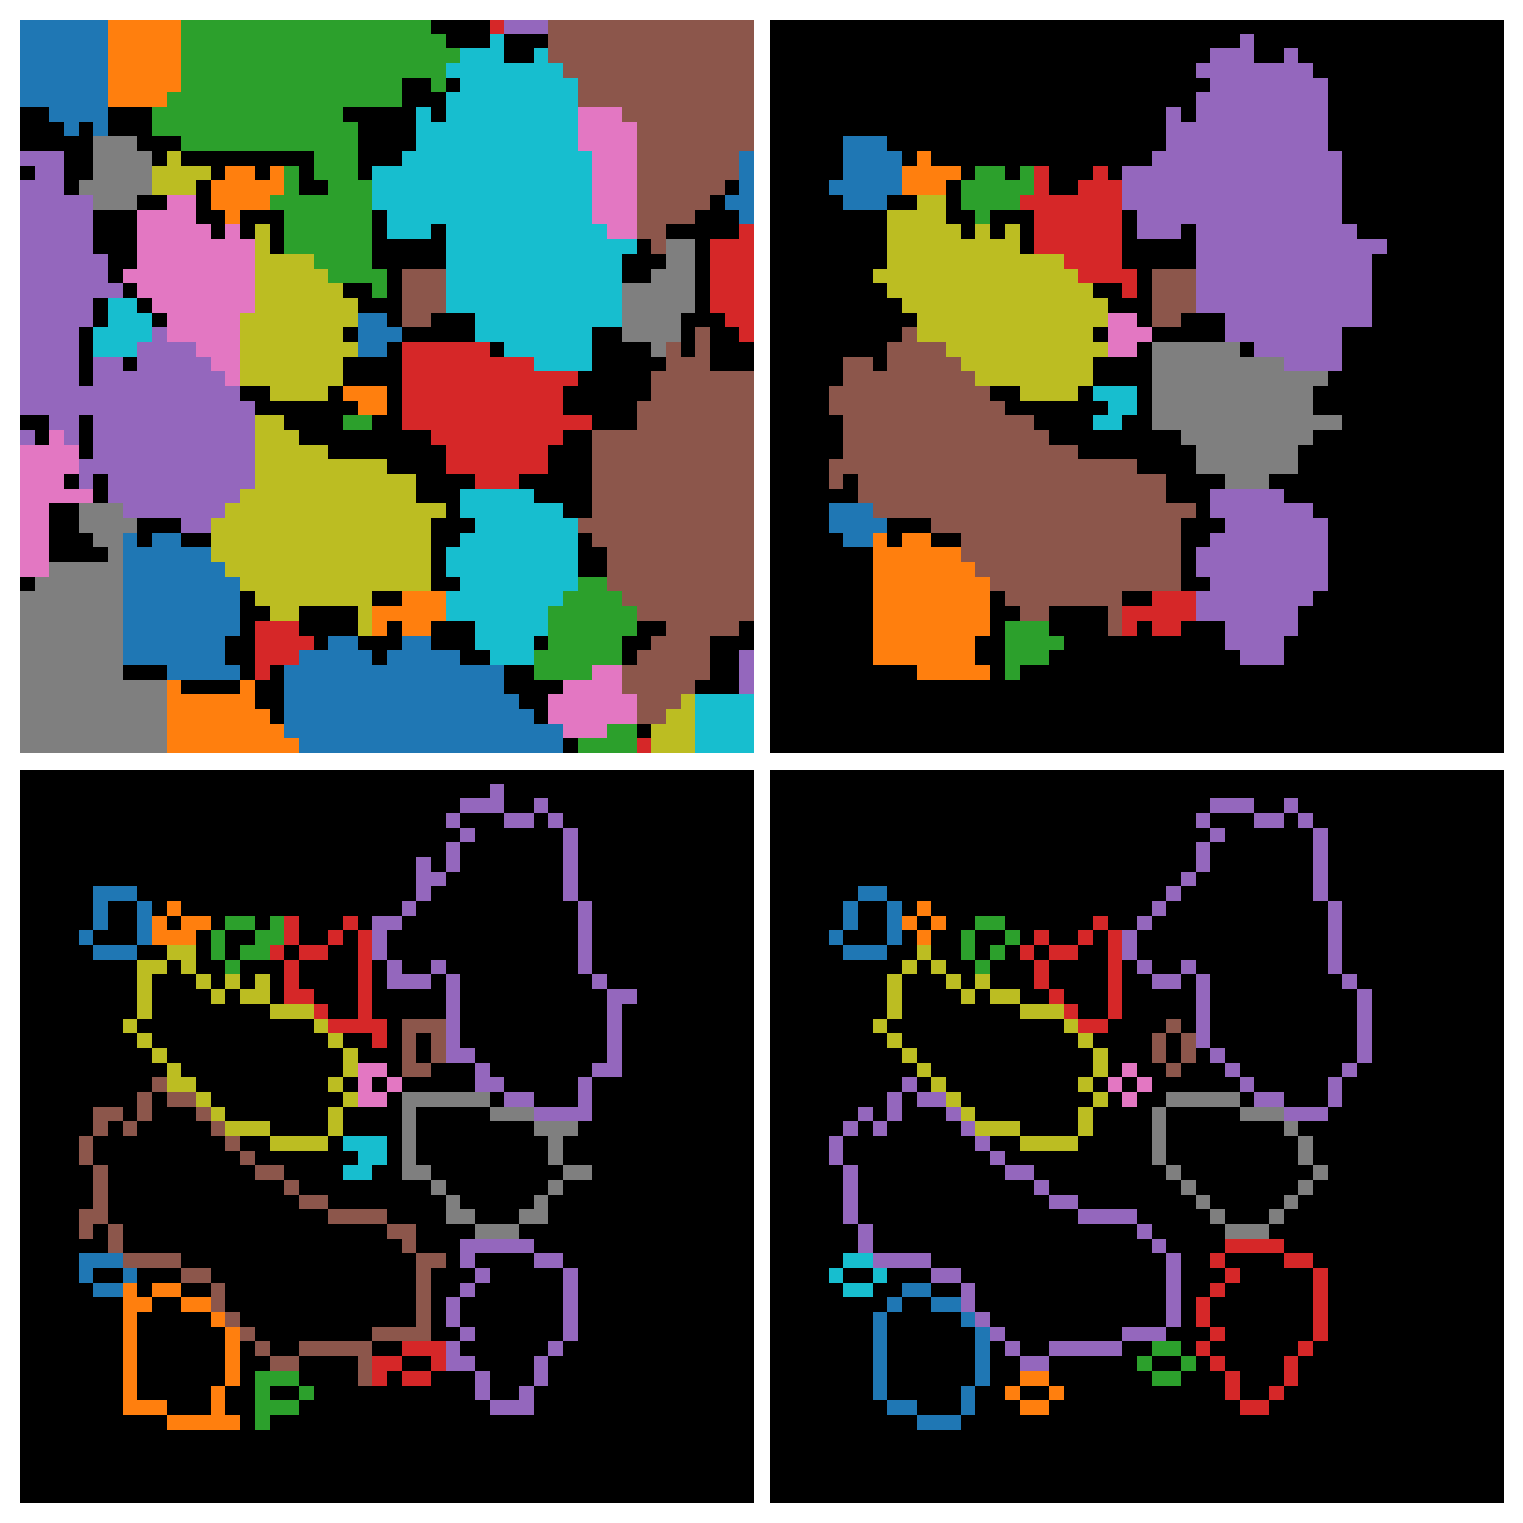

In [15]:
labels = np.unique(img_1_merged)
# Difference between region & eroded region
img_1_bounds = np.zeros_like(img_1_merged)
# Overlap between bounds and eroded -> dilated bounds
img_1_clean = np.zeros_like(img_1_merged)
for i in labels[labels > 0]:
# for i in [9]:
    # Isolate/binarize region label
    reg_bin = np.zeros_like(img_1_merged)
    reg_bin[img_1_merged == i] = 1
    # Create bounds by subtracting eroded region
    reg_bounds = reg_bin - morphology.binary_erosion(reg_bin)
    # Set resulting bounds to original label in collection
    img_1_bounds[reg_bounds == 1] = i
    # Clean bounds by taking overlap of original bounds with eroded/dilated
    reg_bin_ero_dil = morphology.binary_erosion(reg_bin)
    reg_bin_ero_dil = morphology.binary_dilation(reg_bin_ero_dil)
    img_1_clean[(reg_bounds == 1) & (reg_bin_ero_dil == 1)] = i
fig, ax = view.images([
    view.color_labels(img_1, return_image=True),
    view.color_labels(img_1_merged, return_image=True),
    view.color_labels(img_1_bounds, return_image=True),
    view.color_labels(img_1_clean, return_image=True),
], imgs_per_row=2, dpi=200)

In [16]:
region_table = measure.regionprops_table(img_1_clean, properties=('label', 'bbox'))
bbox_df = pd.DataFrame(region_table)
bbox_df.rename(columns={
    'bbox-0': 'min_row',
    'bbox-1': 'min_col',
    'bbox-2': 'max_row',
    'bbox-3': 'max_col',
}, inplace=True)
bbox_df['ums_per_pixel'] = [ums_per_pixel] * bbox_df.index.shape[0]
bbox_df.head()
bbox_df.to_csv('../results/idox_estane_sem2_subarea/bounding_boxes.csv')

In [17]:
regions = measure.regionprops(img_1_clean)
for region in regions:
    coords = region.coords
    x = coords[:, 1]
    y = coords[:, 0]
    df = pd.DataFrame(data={'x': x, 'y': y})
    df.to_csv(
        f'../results/idox_estane_sem2_subarea/{str(region.label).zfill(2)}.csv')
df.head()

,x,y
0,9,21
1,8,22
2,10,22
3,11,22
4,6,23


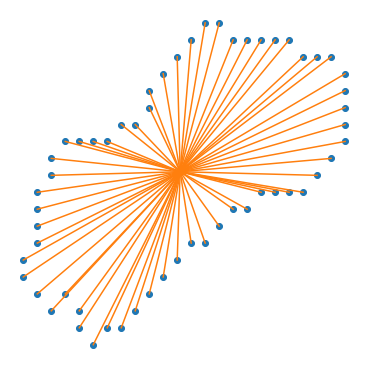

In [81]:
fig, ax = plt.subplots(
    facecolor='white', figsize=(5, 5), constrained_layout=True)
ax.scatter(coords[:, 1], coords[:, 0])
cent=(sum(coords[:, 1])/len(coords), sum(coords[:, 0])/len(coords))
for i in range(len(coords)):
    ax.plot((coords[i, 1], cent[0]), (coords[i, 0], cent[1]), c='C1')
ax.scatter(*cent)
ax.set_axis_off()

(57, 2)


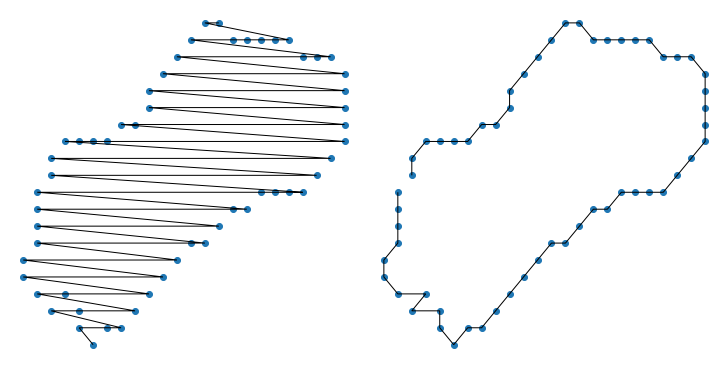

In [90]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), constrained_layout=True, facecolor='white')
axes[0].scatter(coords[:, 1], coords[:, 0])
axes[0].add_patch(
    patches.Polygon(np.flip(coords), closed=False, fill=False))
# Compute centroid
# cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
cent=(sum(coords[:, 1])/len(coords),sum(coords[:, 0])/len(coords))
# Sort by polar angle
# pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
ordered = np.array(
    # math.atan2(y, x) returns atan(y / x) in the correct quadrant
    sorted(coords, key=lambda p: math.atan2(p[0]-cent[1], p[1]-cent[0])))
print(ordered.shape)
ordered_loop = np.zeros((ordered.shape[0] + 1, 2))
ordered_loop[-1, :] = ordered[0, :]
ordered_loop[:-1, :] = ordered
# Plot points
# pylab.scatter([p[0] for p in pp], [p[1] for p in pp])
axes[1].scatter(ordered[:, 1], ordered[:, 0])
axes[1].add_patch(
    patches.Polygon(np.flip(ordered_loop), closed=False, fill=False))
for a in axes:
    a.set_axis_off()